In [1]:
from head import opentrons
import pandas as pd
import numpy as np
from scipy.spatial import distance
import warnings
warnings.filterwarnings("ignore")

INFO: Using numpy backend


In [2]:
class Simulator:
    def __init__(self):
        self.domain = np.linspace(-5,5,num=100)
        
    def generate(self, mu, sig):
        scale = 1/(np.sqrt(2*np.pi)*sig)
        return scale*np.exp(-np.power(self.domain - mu, 2.) / (2 * np.power(sig, 2.)))
    
    def process_batch(self, Cb, fname):
        out = []
        for c in Cb:
            out.append(self.generate(*c))
        out = np.asarray(out)
        df = pd.DataFrame(out.T, index=self.domain)
        df.to_excel(fname, engine='openpyxl')
        
        return 
    
    def make_target(self, ct):
        return self.domain, self.generate(*ct)

In [3]:
sim = Simulator()
target = np.array([-2,0.5])
xt, yt = sim.make_target(target)

In [4]:
from head import AmplitudePhaseDistance

def APdist(f1,f2):
    da, dp = AmplitudePhaseDistance(f1+1e-6,f2+1e-6,xt)
    
    return -(da+dp)
    

In [5]:
Cmu = [-10,10]
Csig = [0.1,3.5]
bounds = [Cmu, Csig]

In [6]:
optim = opentrons.Optimizer(xt, yt, 
                            bounds, 
                            savedir = '../data',
                            batch_size=4,
                            metric = APdist
                           )


INFO: Getting suggestions for iteration 0
INFO: Iteration : 0, Samples to be made
INFO: 0	[-9.06966002  2.36991469]
INFO: 1	[1.23088888 1.86821476]
INFO: 2	[-9.51193356  2.15804688]
INFO: 3	[-7.16004485  0.98395696]
INFO: ==============================


In [7]:
# random iteration
optim.save()
C0 = np.load('../data/0/new_x.npy')
sim.process_batch(C0, '../data/0.xlsx')
optim.update('../data/0.xlsx')
optim.save()
optim.get_current_best()

INFO: Iteration : 1 Best estimate [[2.08358916 1.72105514]] with predicted score : [[-0.58907737]]


In [8]:
for i in range(1,21):
    # iteration i selection
    optim.suggest_next()
    optim.save()
    # simulate iteration i new_x 
    Ci = np.load('../data/%d/new_x.npy'%i)
    sim.process_batch(Ci, '../data/%d.xlsx'%i)
    optim.update('../data/%d.xlsx'%i)
    optim.save()
    optim.get_current_best()

INFO: Getting suggestions for iteration 1
INFO: Iteration : 1, Samples to be made
INFO: 0	[5.56210297 3.10359006]
INFO: 1	[-7.45539913  2.78036055]
INFO: 2	[2.63649676 1.14913492]
INFO: 3	[-6.78436901  3.26759032]
INFO: ==============================
INFO: Iteration : 2 Best estimate [[2.21282232 1.178545  ]] with predicted score : [[-0.55740596]]
INFO: Getting suggestions for iteration 2
INFO: Iteration : 2, Samples to be made
INFO: 0	[8.53580162 0.2182593 ]
INFO: 1	[-7.90008706  1.85549824]
INFO: 2	[1.69766503 0.84827989]
INFO: 3	[4.3895987  1.10274336]
INFO: ==============================
INFO: Iteration : 3 Best estimate [[-0.32576965  0.84315363]] with predicted score : [[-0.41772651]]
INFO: Getting suggestions for iteration 3
INFO: Iteration : 3, Samples to be made
INFO: 0	[-3.72139789  0.1034    ]
INFO: 1	[2.46601843 0.14061049]
INFO: 2	[-1.60743259  0.1034    ]
INFO: 3	[2.95917021 0.39968057]
INFO: ==============================
INFO: Iteration : 4 Best estimate [[2.37811031 0.

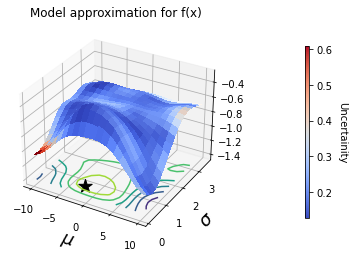

In [9]:
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource
from matplotlib import cm
from matplotlib.colors import Normalize
import head
import torch
tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}

fig, ax = plt.subplots(subplot_kw={'projection':'3d'})

ax.set_xlabel(r'$\mu$', fontsize=18)
ax.set_ylabel(r'$\sigma$', fontsize=18)
with torch.no_grad():
    num_grid_spacing = 20
    mu_grid = np.linspace(*bounds[0], num=num_grid_spacing)
    sig_grid = np.linspace(*bounds[1], num=num_grid_spacing)
    test_x = head.Grid(mu_grid, sig_grid).points
    posterior = optim.model.posterior(optim.inp.transform(torch.tensor(test_x).to(**tkwargs)))
    posterior_mean = posterior.mean.cpu().numpy()
    lower, upper = posterior.mvn.confidence_region()
    confidence = np.abs((lower-upper).numpy())
    ls = LightSource(0, 0)
    rgb = ls.shade(confidence.reshape(num_grid_spacing,num_grid_spacing), 
                   cmap=cm.coolwarm, vert_exag=0.1, blend_mode='soft')
    XX, YY = np.meshgrid(mu_grid, sig_grid)
    Z = posterior_mean.reshape(num_grid_spacing,num_grid_spacing)
    sc = ax.plot_surface(XX, YY, Z, 
                    rstride=1, cstride=1, 
                    facecolors=rgb,
                    linewidth=0, antialiased=False, shade=False)
    ax.contour(XX, YY, Z, zdir='z', offset=-1.4, cmap=cm.viridis)
    ax.scatter(target[0], target[1], zs=-1.4, zdir='z', marker='*', s=200,color='k')
    ax.set_title('Model approximation for f(x)')
    cmap = cm.get_cmap('coolwarm')
    norm = Normalize(vmin=confidence.min(), vmax = confidence.max())
    cax = plt.axes([0.95, 0.2, 0.01, 0.6])        
    cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)
    cbar.ax.set_ylabel('Uncertainity', rotation=270)
    cbar.ax.get_yaxis().labelpad = 15
    
plt.show()

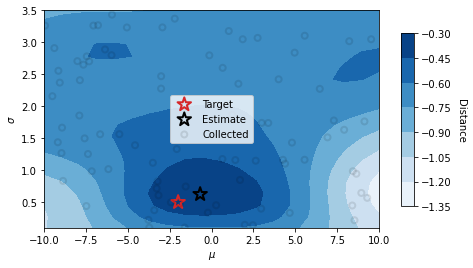

In [16]:
fig, ax = plt.subplots()
im = ax.contourf(XX, YY, Z, cmap=cm.Blues)
ax.scatter(target[0], target[1], 
           marker='*', s=200,color='tab:red', lw=2.0,fc='none', label='Target')
opt_x = optim.best_loc[-1][0]
ax.scatter(opt_x[0], opt_x[1], 
           marker='*', s=200,lw=2.0,fc='none',color='k', label='Estimate')
train_x_unscaled = optim.inp.inverse(optim.train_x)
ax.scatter(train_x_unscaled[:,0], train_x_unscaled[:,1], 
           marker='o', fc='none', edgecolors=(0,0,0), lw=2.0, alpha=0.1, label='Collected')
ax.legend()
ax.set_xlim(bounds[0])
ax.set_ylim(bounds[1])
ax.set_xlabel(r'$\mu$')
ax.set_ylabel(r'$\sigma$')

cmap = cm.get_cmap('coolwarm')
norm = Normalize(vmin=confidence.min(), vmax = confidence.max())
cax = plt.axes([0.95, 0.2, 0.03, 0.6])        
cbar = fig.colorbar(im, cax=cax)
cbar.ax.set_ylabel('Distance', rotation=270)
cbar.ax.get_yaxis().labelpad = 15
plt.show()